In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

In [2]:

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# Image transformations (Resize and Normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB for compatibility with model input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

In [4]:
# Custom dataset for loading the images
class CUFS_Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [5]:

# Load dataset
dataset_path = '/kaggle/input/cuhk-face-sketch-database-cufs/cropped_sketch'
dataset = CUFS_Dataset(root_dir=dataset_path, transform=transform)
# DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)


In [6]:
# Define Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 3 * 64 * 64)

        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(1024)

        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, z):
        z = self.relu(self.batchnorm1(self.fc1(z)))
        z = self.relu(self.batchnorm2(self.fc2(z)))
        z = self.relu(self.batchnorm3(self.fc3(z)))
        z = self.fc4(z)
        z = z.view(-1, 3, 64, 64)
        return self.tanh(z)

In [7]:
# Define Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.fc1 = nn.Linear(512 * 4 * 4, 1)

        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leakyrelu(self.conv1(x))
        x = self.leakyrelu(self.conv2(x))
        x = self.leakyrelu(self.conv3(x))
        x = self.leakyrelu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return self.sigmoid(x)


In [8]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [9]:
# Real and fake labels
real_label = 1
fake_label = 0

In [10]:

# Function to visualize images
def show_images(real_images, fake_images, epoch):
    real_images = real_images.detach().cpu()
    fake_images = fake_images.detach().cpu()
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].imshow(make_grid(real_images, nrow=8).permute(1, 2, 0))
    ax[0].set_title("Real Images")
    ax[0].axis('off')
    
    ax[1].imshow(make_grid(fake_images, nrow=8).permute(1, 2, 0))
    ax[1].set_title(f"Generated Images (Epoch {epoch})")
    ax[1].axis('off')
    
    plt.show()

Epoch [1/50], D Loss: 1.4578, G Loss: 0.8650
Epoch [2/50], D Loss: 0.7201, G Loss: 1.6723
Epoch [3/50], D Loss: 1.7581, G Loss: 3.5184
Epoch [4/50], D Loss: 0.8074, G Loss: 3.3976
Epoch [5/50], D Loss: 0.4287, G Loss: 2.1797
Epoch [6/50], D Loss: 0.7265, G Loss: 2.1766
Epoch [7/50], D Loss: 0.5967, G Loss: 1.9602
Epoch [8/50], D Loss: 0.5177, G Loss: 2.2613
Epoch [9/50], D Loss: 0.6239, G Loss: 2.5482
Epoch [10/50], D Loss: 0.3600, G Loss: 2.1537


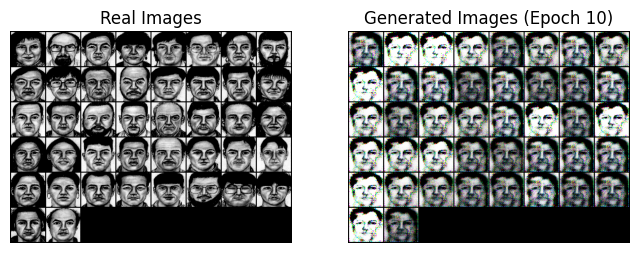

Epoch [11/50], D Loss: 0.7951, G Loss: 3.5481
Epoch [12/50], D Loss: 1.1442, G Loss: 3.6243
Epoch [13/50], D Loss: 0.6202, G Loss: 2.4364
Epoch [14/50], D Loss: 0.3146, G Loss: 2.3835
Epoch [15/50], D Loss: 0.8419, G Loss: 3.2538
Epoch [16/50], D Loss: 0.5205, G Loss: 1.3520
Epoch [17/50], D Loss: 0.3179, G Loss: 1.8362
Epoch [18/50], D Loss: 0.3724, G Loss: 4.7216
Epoch [19/50], D Loss: 0.6433, G Loss: 1.7984
Epoch [20/50], D Loss: 0.6835, G Loss: 3.1382


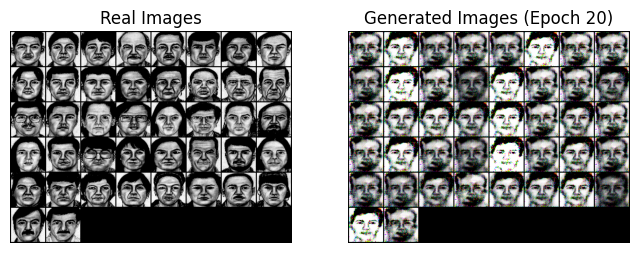

Epoch [21/50], D Loss: 0.6090, G Loss: 2.2446
Epoch [22/50], D Loss: 0.7384, G Loss: 2.8939
Epoch [23/50], D Loss: 1.6305, G Loss: 1.8532
Epoch [24/50], D Loss: 0.8833, G Loss: 1.6568
Epoch [25/50], D Loss: 0.6050, G Loss: 1.8808
Epoch [26/50], D Loss: 0.7779, G Loss: 0.9569
Epoch [27/50], D Loss: 0.6169, G Loss: 1.6578
Epoch [28/50], D Loss: 1.0217, G Loss: 0.9797
Epoch [29/50], D Loss: 0.7210, G Loss: 1.1485
Epoch [30/50], D Loss: 0.7361, G Loss: 1.7256


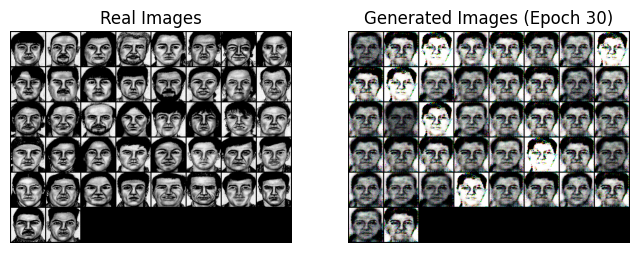

Epoch [31/50], D Loss: 0.8383, G Loss: 1.0421
Epoch [32/50], D Loss: 0.9510, G Loss: 2.8375
Epoch [33/50], D Loss: 0.8710, G Loss: 1.6409
Epoch [34/50], D Loss: 1.0811, G Loss: 1.5522
Epoch [35/50], D Loss: 0.7016, G Loss: 1.5404
Epoch [36/50], D Loss: 0.8135, G Loss: 1.4186
Epoch [37/50], D Loss: 1.1033, G Loss: 1.8493
Epoch [38/50], D Loss: 0.8928, G Loss: 2.0488
Epoch [39/50], D Loss: 0.9471, G Loss: 1.6221
Epoch [40/50], D Loss: 1.0510, G Loss: 1.8226


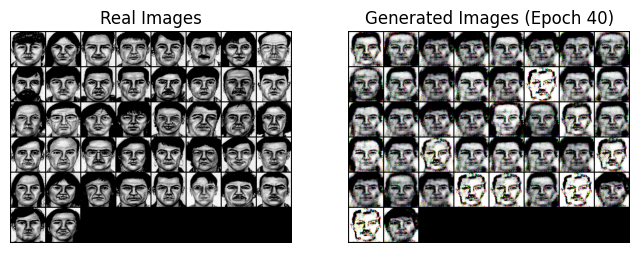

Epoch [41/50], D Loss: 1.1254, G Loss: 1.1369
Epoch [42/50], D Loss: 1.0816, G Loss: 1.0221
Epoch [43/50], D Loss: 1.0469, G Loss: 2.0112
Epoch [44/50], D Loss: 0.9413, G Loss: 1.3776
Epoch [45/50], D Loss: 1.1286, G Loss: 1.2420
Epoch [46/50], D Loss: 0.8191, G Loss: 2.7562
Epoch [47/50], D Loss: 0.9864, G Loss: 1.4121
Epoch [48/50], D Loss: 1.0175, G Loss: 1.5026
Epoch [49/50], D Loss: 0.8982, G Loss: 1.6978
Epoch [50/50], D Loss: 0.9977, G Loss: 1.1655


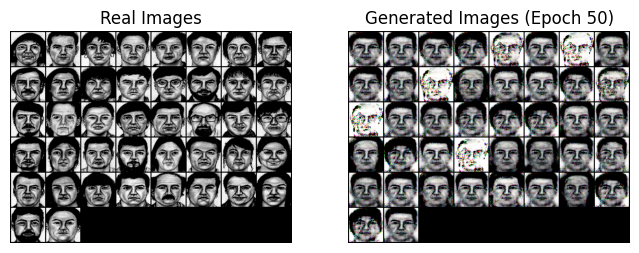

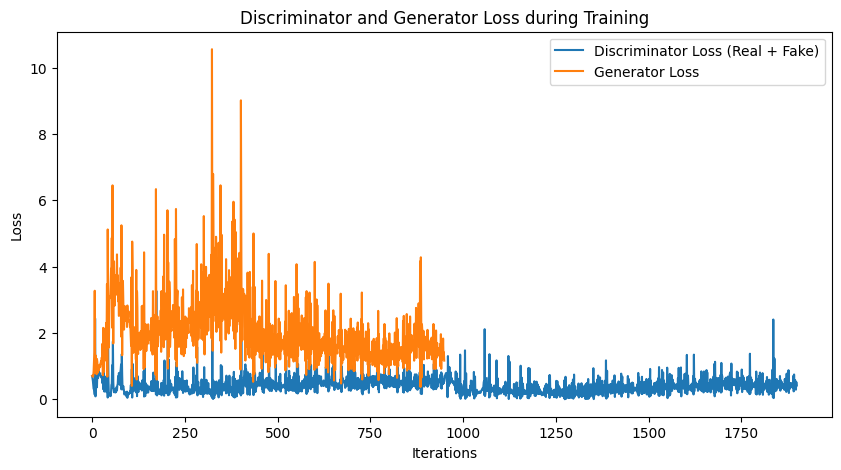

In [11]:

# Training loop
num_epochs = 50
real_loss = []
fake_loss = []
g_loss_list = []  # Track generator loss

for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Train Discriminator
        optimizer_d.zero_grad()
        
        # Real images
        labels = torch.full((batch_size,), real_label, device=device, dtype=torch.float32)  # Convert to float32
        output = discriminator(real_images)
        d_loss_real = criterion(output.view(-1), labels)
        d_loss_real.backward()

        # Fake images
        noise = torch.randn(batch_size, 100, device=device)
        fake_images = generator(noise)
        labels.fill_(fake_label)
        output = discriminator(fake_images.detach())
        d_loss_fake = criterion(output.view(-1), labels)
        d_loss_fake.backward()

        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        labels.fill_(real_label)
        output = discriminator(fake_images)
        g_loss = criterion(output.view(-1), labels)
        g_loss.backward()

        optimizer_g.step()

        # Record losses
        real_loss.append(d_loss_real.item())
        fake_loss.append(d_loss_fake.item())
        g_loss_list.append(g_loss.item())  # Track generator loss

    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}")
    
    # Show images and loss plot
    if (epoch+1) % 10 == 0:
        show_images(real_images, fake_images, epoch+1)

# Plot the losses (Discriminator and Generator)
plt.figure(figsize=(10,5))
plt.plot(real_loss + fake_loss, label='Discriminator Loss (Real + Fake)')
plt.plot(g_loss_list, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator and Generator Loss during Training')
plt.show()




In [12]:

# OR: Save just the state_dict (recommended)
torch.save(generator.state_dict(), 'DCGAN_generator_state_dict.pth')
torch.save(discriminator.state_dict(), 'DCGAN_discriminator_state_dict.pth')


In [13]:
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision import transforms
import torch
from torch.utils.data import DataLoader

# Load InceptionV3 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = Inception_V3_Weights.IMAGENET1K_V1
inception = inception_v3(weights=weights).to(device)
inception.fc = torch.nn.Identity()  # Remove final classification layer
inception.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Normalize((0.5,), (0.5,))
])

def preprocess_images(images):
    if images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)  # Grayscale to RGB
    return torch.stack([transform(img.cpu()) for img in images])

def get_activations(images, model, batch_size=32, dims=2048):
    dataloader = DataLoader(images, batch_size=batch_size)
    pred_arr = np.empty((len(images), dims))
    start_idx = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            pred = model(batch).view(batch.size(0), -1)
            pred_arr[start_idx:start_idx + batch.size(0)] = pred.cpu().numpy()
            start_idx += batch.size(0)

    return pred_arr

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Make sure your variables are named `test_images` and `generated_images`
real_images = real_images.to(device)
fake_images = fake_images.to(device)

real_images = preprocess_images(real_images)
fake_images = preprocess_images(fake_images)

# Calculate activations and FID
act1 = get_activations(real_images, inception)
act2 = get_activations(fake_images, inception)

fid_score = calculate_fid(act1, act2)
print("FID Score:", fid_score)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 216MB/s] 


FID Score: 199.34920775818387
